In [14]:
import os
import json
import pandas as pd

RESULTS_ROOT = "/mnt/hdd/ttoxopeus/basic_UNet/results"
MODEL_NAME = "UNet_ACDC"  # change if needed


def _read_json(path: str) -> dict | None:
    if not os.path.isfile(path):
        return None
    with open(path, "r") as f:
        return json.load(f)


def _flatten_eval_metrics(d: dict, run_name: str, run_path: str) -> dict:
    """
    Turns your eval_metrics.json dict into a single flat row.
    Expands per_class into columns.
    """
    row = {
        "run_name": run_name,
        "run_path": run_path,
        "phase": d.get("phase"),
        "params_m": d.get("params_m"),
        "flops_g": d.get("flops_g"),
        "inference_ms": d.get("inference_ms"),
        "vram_peak_mb": d.get("vram_peak_mb"),
        "mean_dice_fg": d.get("mean_dice_fg"),
        "std_dice_fg": d.get("std_dice_fg"),
        "mean_iou_fg": d.get("mean_iou_fg"),
        "std_iou_fg": d.get("std_iou_fg"),
    }

    per_class = d.get("per_class", {}) or {}
    for cls_name, cls_metrics in per_class.items():
        cls_slug = cls_name.lower().replace(" ", "_")
        row[f"{cls_slug}_dice_mean"] = cls_metrics.get("dice_mean")
        row[f"{cls_slug}_dice_std"] = cls_metrics.get("dice_std")
        row[f"{cls_slug}_iou_mean"] = cls_metrics.get("iou_mean")
        row[f"{cls_slug}_iou_std"] = cls_metrics.get("iou_std")

    return row


def load_experiment_eval_df(
    exp_name: str,
    required_substring: str | None = None,
    pruned_eval_relpath: str = os.path.join("retrained_pruned_evaluation", "eval_metrics.json"),
    baseline_eval_relpath: str = os.path.join("baseline", "evaluation", "eval_metrics.json"),
    model_name: str = MODEL_NAME,
    results_root: str = RESULTS_ROOT,
) -> pd.DataFrame:
    """
    Returns a DataFrame for one experiment:
    - Row 0 = baseline evaluation
    - Following rows = each pruned run under /pruned/*

    Filter:
      required_substring: only include pruned folders whose name contains this substring
    """
    exp_root = os.path.join(results_root, model_name, exp_name)

    # -------- baseline first --------
    baseline_path = os.path.join(exp_root, baseline_eval_relpath)
    baseline_json = _read_json(baseline_path)
    if baseline_json is None:
        raise FileNotFoundError(f"Baseline eval_metrics.json not found at: {baseline_path}")

    rows = [
        _flatten_eval_metrics(
            baseline_json,
            run_name="baseline",
            run_path=os.path.dirname(baseline_path),
        )
    ]

    # -------- pruned runs --------
    pruned_dir = os.path.join(exp_root, "pruned")
    if not os.path.isdir(pruned_dir):
        df = pd.DataFrame(rows)
        # add model_size_pct even if only baseline exists
        df["model_size_pct"] = 100.0
        return df

    for run_name in sorted(os.listdir(pruned_dir)):
        run_path = os.path.join(pruned_dir, run_name)
        if not os.path.isdir(run_path):
            continue

        # Filter only PRUNED runs (baseline is always included above)
        if required_substring and required_substring not in run_name:
            continue

        metrics_path = os.path.join(run_path, pruned_eval_relpath)
        d = _read_json(metrics_path)
        if d is None:
            continue

        rows.append(_flatten_eval_metrics(d, run_name=run_name, run_path=run_path))

    df = pd.DataFrame(rows)

    if df.empty:
        return df

    # --------------------------
    # Add model size (% of baseline params)
    # --------------------------
    baseline_params = df.loc[df["run_name"] == "baseline", "params_m"].iloc[0]
    df["model_size_pct"] = 100.0 * df["params_m"] / baseline_params

    # Nice ordering: baseline first, then pruned sorted by params (descending) or dice (descending)
    is_baseline = df["run_name"].eq("baseline")
    df_pruned = df.loc[~is_baseline].sort_values(
        ["params_m", "mean_dice_fg"], ascending=[False, False]
    )
    df = pd.concat([df.loc[is_baseline], df_pruned], ignore_index=True)

    # Put key columns up front
    front = [
        "run_name",
        "phase",
        "model_size_pct",
        "params_m",
        "flops_g",
        "inference_ms",
        "vram_peak_mb",
        "mean_dice_fg",
        "std_dice_fg",
        "mean_iou_fg",
        "std_iou_fg",
        "run_path",
    ]
    df = df[front + [c for c in df.columns if c not in front]]

    return df


# --------------------------
# Example usage
# --------------------------
EXP_NAME = "exp56_stone"

# Only pruned folders containing this substring (baseline will STILL be included)
df = load_experiment_eval_df(EXP_NAME, required_substring="0_0_0_99_99_99_99_99_0_0_0")

pd.set_option("display.max_rows", None)
display(df)

,run_name,phase,model_size_pct,params_m,flops_g,inference_ms,vram_peak_mb,mean_dice_fg,std_dice_fg,mean_iou_fg,...,rv_iou_mean,rv_iou_std,myocardium_dice_mean,myocardium_dice_std,myocardium_iou_mean,myocardium_iou_std,lv_dice_mean,lv_dice_std,lv_iou_mean,lv_iou_std
0,baseline,baseline_evaluation,100.000000,43.886340,54.440493,2.419848,449.635254,0.449914,0.296118,0.392090,...,0.153430,0.303506,0.580217,0.344097,0.485239,0.319461,0.589780,0.419893,0.537600,0.404098
1,corr_t98_0_0_0_99_99_99_99_99_0_0_0,retrained_pruned_evaluation,78.391588,34.403199,48.687963,2.790446,389.035156,0.348228,0.266426,0.302856,...,0.046909,0.211444,0.475156,0.366081,0.389366,0.327091,0.522619,0.429661,0.472293,0.410500
2,corr_t96_0_0_0_99_99_99_99_99_0_0_0,retrained_pruned_evaluation,43.511252,19.095496,44.386200,2.465477,194.894531,0.461093,0.266124,0.411962,...,0.090355,0.258178,0.644811,0.337162,0.553795,0.316523,0.637036,0.419909,0.591734,0.405794
3,corr_t94_0_0_0_99_99_99_99_99_0_0_0,retrained_pruned_evaluation,26.634413,11.688869,40.938815,2.107224,211.367188,0.347390,0.282498,0.294476,...,0.089540,0.240032,0.474531,0.360952,0.386099,0.320692,0.460074,0.423444,0.407790,0.399856
4,corr_t90_0_0_0_99_99_99_99_99_0_0_0,retrained_pruned_evaluation,15.392881,6.755372,38.130980,1.940880,146.014160,0.418350,0.267451,0.364062,...,0.080747,0.235329,0.549687,0.352590,0.456553,0.322464,0.610754,0.408307,0.554885,0.395575
5,corr_t85_0_0_0_99_99_99_99_99_0_0_0,retrained_pruned_evaluation,11.272587,4.947126,36.929460,1.890979,158.052246,0.457549,0.263673,0.399922,...,0.102085,0.259056,0.618318,0.330075,0.520179,0.307577,0.634011,0.401086,0.577504,0.389449
6,corr_t75_0_0_0_99_99_99_99_99_0_0_0,retrained_pruned_evaluation,8.917859,3.913722,36.169575,1.762004,164.360352,0.261301,0.266057,0.208724,...,0.101692,0.256123,0.368187,0.323637,0.280416,0.280007,0.294705,0.369778,0.244064,0.332268
7,corr_t40_0_0_0_99_99_99_99_99_0_0_0,retrained_pruned_evaluation,8.337562,3.659051,35.915397,1.603122,132.196777,0.476357,0.289728,0.401087,...,0.192465,0.270663,0.603449,0.324467,0.501146,0.300988,0.572191,0.405047,0.509650,0.387685
8,corr_t30_0_0_0_99_99_99_99_99_0_0_0,retrained_pruned_evaluation,8.337562,3.659051,35.915397,1.641936,132.196777,0.454519,0.199340,0.387737,...,0.046909,0.211444,0.638906,0.276932,0.522377,0.263944,0.677742,0.333766,0.593927,0.327177
9,corr_t50_0_0_0_99_99_99_99_99_0_0_0,retrained_pruned_evaluation,8.337562,3.659051,35.915397,1.603951,132.196777,0.301226,0.271351,0.254918,...,0.057833,0.209550,0.418839,0.364105,0.338181,0.321498,0.418471,0.421197,0.368740,0.394511


0    100.000000
1     78.391588
2     43.511252
3     26.634413
4     15.392881
5     11.272587
6      8.917859
7      8.337562
8      8.337562
9      8.337562
Name: model_size_pct, dtype: float64


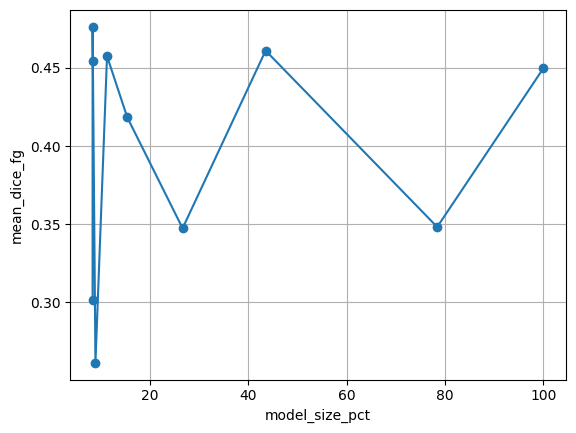

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_df_xy(df, x_col, y_col):
    plt.figure()
    plt.plot(df[x_col], df[y_col], marker='o')
    plt.xlabel(x_col)
    plt.ylabel(y_col)

    plt.xlim(100, 0)   
    plt.ylim(0, 1)     

    plt.grid(True)
    plt.show()


plot_df_xy(df, "model_size_pct", "mean_dice_fg")

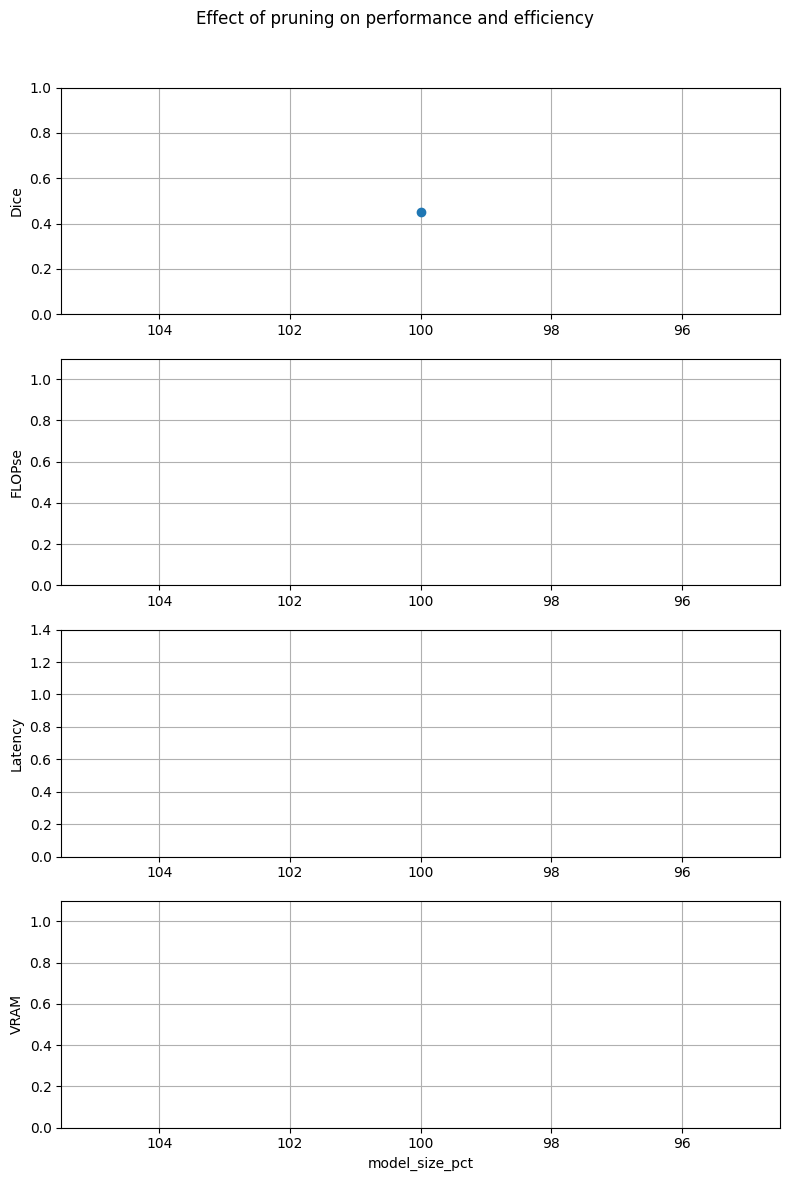

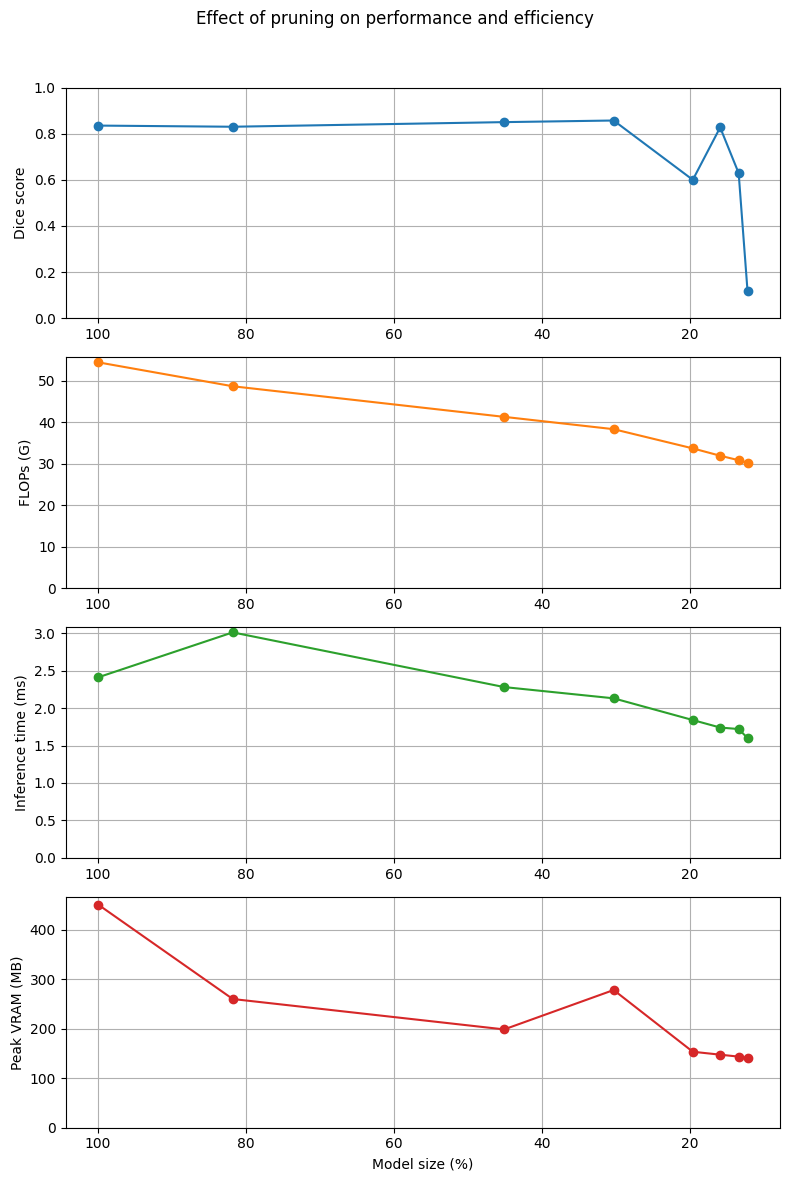

In [ ]:
import matplotlib.pyplot as plt

# Pruning percentages / model size (%)
# model_size = [100, 81.8, 45.1, 30.3, 19.6, 15.9, 13.4, 12.2]
#model_size = [100, 81.8, 45.1, 30.3, 19.6, 15.9, 13.4, 12.2]
num_params = [43.9, 34.4, 19.4]

# Metrics
dice = [0.835, 0.35, 0.29]
flops = [54.44, 48.68, 40.2]
inference = [2.41, 2.79, 2.21]
vram = [450.89, 389.0, 197.1]

# Taller figure
plt.figure(figsize=(8, 12))

# Dice
plt.subplot(4, 1, 1)
plt.plot(model_size, dice, marker='o', color='tab:blue')
plt.ylabel("Dice score")
plt.ylim(0, 1)
plt.gca().invert_xaxis()
plt.grid(True)

# FLOPs
plt.subplot(4, 1, 2)
plt.plot(model_size, flops, marker='o', color='tab:orange')
plt.ylabel("FLOPs (G)")
plt.ylim(bottom=0)
plt.gca().invert_xaxis()
plt.grid(True)

# Inference time
plt.subplot(4, 1, 3)
plt.plot(model_size, inference, marker='o', color='tab:green')
plt.ylabel("Inference time (ms)")
plt.ylim(bottom=0)
plt.gca().invert_xaxis()
plt.grid(True)

# VRAM
plt.subplot(4, 1, 4)
plt.plot(model_size, vram, marker='o', color='tab:red')
plt.xlabel("Model size (%)")
plt.ylabel("Peak VRAM (MB)")
plt.ylim(bottom=0)
plt.gca().invert_xaxis()
plt.grid(True)

plt.suptitle("Effect of pruning on performance and efficiency on STONE dataset")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
